<a href="https://colab.research.google.com/github/HyeSeong-Lee/NLP-ELECTRA/blob/main/ELECTRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Electra 모델 리뷰


### 1. 모델의 구조
위 사진에서 보이는 바와 같이, ELECTRA모델은 generator 네트워크와 discriminator네트워크로 구성되어 있습니다. 두 네트워크는 Transformer의 인코더 구조를 취하고 있으며, 토큰 시퀀스 $𝐗=[x_1, x_2,...x_n]$를 입력으로 받아 문맥 정보를 반영해 $h(𝐗)=[h_1, h_2, ...,h_n]$를 만들어냅니다.


### 2. Generator
Generator는 입력받은 토큰벡터의 일부를 마스킹해 이를 예측값으로 체워넣는 기능을 합니다. 
Generator의 동작 방식은 아래와 같습니다.

1. $𝖒=[m_1,m_2,..,m_k]$ (여기서 임의의 $m_i$는 마스킹할 위치의 집합입니다.) 전체 토큰의 15%만 마스킹하기 때문에, $k=0.15n$입니다(모델에 구조에서 토큰의 개수가 n개 있음을 내포했다는 것을 염두해둡시다)
2. 𝐗[index] = MASK, (where index∈𝖒) - 코드를 살펴보면, input 원본에 masking을 하는 것이 아니라, 마스킹된 위치 정보(𝖒)를 이용해 어디가 masking되었는지 명시하고, 아래의 작업을 수행하는데, 아래 작업 역시 원본 정보를 수정하는 것이 아니라, 새롭게 변수를 선언해 그 변수에 할당해줍니다. 
3. 마스킹된 $t$번째 토큰을 예측한다고 한다면 $p_G(x_t|x^{masked})=exp(e(x_t)^Th_G(x^{masked})_t)/Σ_{x\prime}exp(e(x\prime)^Th_G(x^{masked})_t)$을 사용합니다. 여기서 $e()$는 임베딩을 의미합니다. 위 식이 output이 되는데, 이 output은 주어진 위치 $t$에 대해 어떤 토큰 $x_t$를 생성할 확률입니다.
4. 해당 과정을 거치고, 사용하는 loss는 MLM loss로 다음과 같습니다. $ℒ_{MLM}(𝐗,Θ_G)=E(Σ_{i∈m}(-log(p_G(x_i|𝐗^{masked}))))$

  MLM이란, Bert에서 큰 corpus 데이터셋을 가공하지 않고 self-supervised learning를 통해 토큰 임베딩을 학습시킬 때 사용하는 방식입니다. 이 과정은 쉽게 말하면, 입력에 노이즈가 들어간 것을 원래대로 복구하는 과정이라고 보시면 됩니다.

5. 위의 loss를 활용해 학습할 때는, discriminator와 같이 학습되는 것이 아니라, 단독으로 학습합니다. 이에 대한 이유는 후술하겠습니다.

6. 결국, generator가 만든 output은 discriminator가 구분할 수 없습니다. 추후 서술하겠지만, discriminator는 어떤 토큰 masking된 토큰이 예측되어 다른 토큰으로 체워져 넘어온 것인지, 그대로 넘어온 것인지 맞추는 작업을 하는데, generator에서 낸 output을 바로 구분할 수는 없습니다. 즉, generator는 정답을 맞추는 것을 목적으로 하는 것이 아니라, generator가 구분할 수 없는 output을 생성하는 것을 목표로 해야 합니다.

Generator에 대한 코드는 run_pretrain.py의 52~97번째 줄에 작성되어져 있습니다.

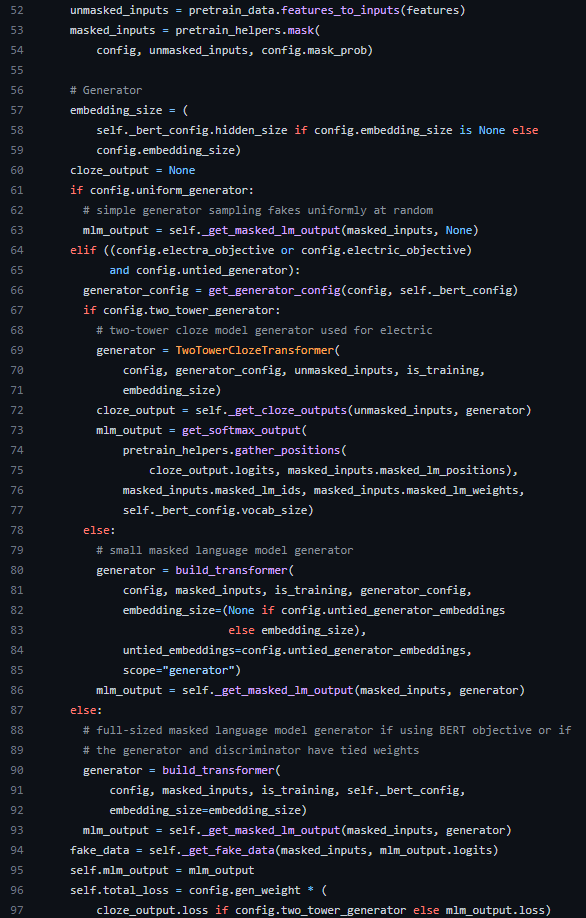

코드의 주석에서는 56번째 줄 부터 generator라고 설명되어있지만, input에 대해 masking을 수행해 𝖒을 만들어내는 작업(1번에 대한 작업)은 53, 54번째 줄에서 시행되며, 해당 값이 masked_input에 저장되는 것으로 보아, 𝖒은 코드상으로 masked_input을 의미합니다. 또한, 위에서 un_masked_input에 데이터를 넣는 것으로 보아, unmasked_input이 𝐗를 의미하는 변수일 것입니다.

Generator에 대한 output은 조건문에 따라 다르게 정의됩니다. 다만, 코드를 읽어보니, Generator를 단순히 Discriminator에 전달해줄 output, 즉, masking된 토큰을 예측값으로 넣어 완성된 토큰벡터를 만드는 코드는 67-77번째 줄에 작성되어 있다는 것을 알 수 있습니다. 이 말은, 주석에는 56번째 줄 부터 generator라고 정의되어 있지만, 실제로 generator가 정의되어 output을 만들어내는 코드는 67-77번째 줄 까지라는 뜻입니다. 77번째 줄을 읽어보면, mlm_output에 get_softmax_output함수의 리턴값을 할당하는 것을 볼 수 있는데, 해당 함수로 가보면(271번째 줄) discriminator의 output을 계산하는 자세한 코드가 나와있습니다.

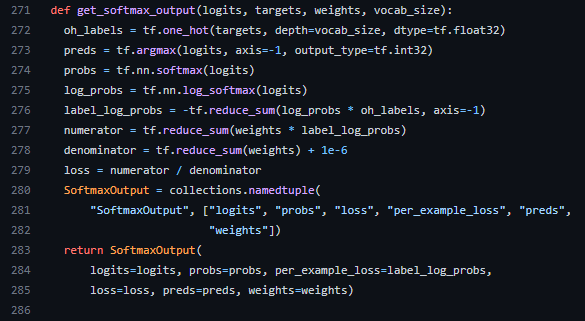

우선, 다시 generator 코드로 돌아와 77번째 줄에 인자로 전달되는 것을 살펴보면, 첫번째 인자로 gather_positions라는 함수의 결과가 들어가는데, gather_positions에 전달되는 인자는 cloze_output의 logit값과 masked_inputs의 위치정보가 들어갑니다. cloze_output은 72번째 줄에서 구해지는데, masking된 토큰을 예측한 것이고 이렇게 예측한 것을 가지고 어디에 마스킹이 되어있는지에 대한 정보와 결합해 사실상 2번의 작업을 하는 것이라고 보면 됩니다. 3번의 작업은 get_softmax_output함수가 수행되는 과정 속에서 수행되고

그렇게 계산된 output은 95번째 줄에서 클래스의 멤버변수에 할당되고, 96번째 줄에서 loss를 계산합니다.








### 3. Discriminator
Discriminator는 입력받은 각 토큰이 masking된 것을 예측해서 들어온 것인지, 그대로 온 것인지 이진분류를 통해 구분합니다. ELECTRA모델이 학습을 한다라고 한다는 것은 Discriminator가 학습된다는 것입니다. Generator로 부터 만들어진 토큰 벡터를 가지고, 아래의 과정을 수행합니다.

1. 앞서 Generator에서 만들어진 $m$에서 $m_i$에 위치하는 토큰을 "MASK"가 아닌, generator의 softmax분포 $p_G(x_t|𝑿)$에 대해 샘플링한 토큰으로 치환합니다. 여기선 masking되었다는 표현 대신, corrupt되었다고 표현합니다.

2. 치환된 입력에 대해 원래 입력과 같은지 치환된 것인지 예측합니다. $t$번째 토큰에 대한 예측을 한다고 가정하면 다음과 같은 수식을 이용합니다. $D(𝑿^{corrupt},t)=sigmoid(w^Th_D(𝑿^{corrupt})_t)$

3. 이에 대한 loss는 다음과 같이 계산됩니다. $ℒ_{Disc}(𝑿,Θ_D)=E(Σ_{t=1}^n(result_t))$

  $$ result_t=
\begin{cases}
-log(D(𝗑^{corrupt},t),\;(if\;x_t^{corrupt}=x_t)\\
-log(1-D(𝗑^{corrupt},t),\;(if\;x_t^{corrupt}\neq x_t)
\end{cases}$$

4. 위의 수식이 하는 역할은 real과 fake를 구분한다는 것입니다. 이는 GAN과 차이를 보이는 점입니다. 수식이 어렵게 되어있지만, 결국 Binery cross entropy를 말하는 것입니다.

Discriminator의 코드는 99-108번째 줄에 작성되어있습니다. 

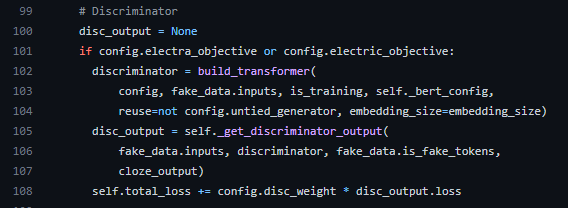

102-103번째 줄을 보면 알 수 있듯, discriminator가 선언될 때 fake_data라는 것이 인자로 전달됩니다. 사실 fake_data는 Generator에 대한 코드 후반부인 94번째 줄에서 만들어지는데, 이는 Generator에서 더이상 활용되지 않고 Discriminator에서만 활용됩니다. fake_data는 Generator에서 토큰 벡터의 마스킹된 부분을 예측값으로 넣어 완성된 토큰 벡터입니다. 여기서, cloze_output과 헷갈릴 수 있는데, cloze_output은 마스킹된 자리에 들어갈 만한 것의 예측값들만의 벡터이고, fake_data는 마스킹된 자리에 cloze_output이 제대로 배치된 결과입니다. Discriminator의 output이 정의되는 코드는 105-107번째 줄이고, loss는 108번째 줄에서 계산됩니다.

### 문제점
- 만일, generator가 masking된 토큰을 맞춰버린다면, 그 토큰은 discriminator에서 masking되어 온 것이 아니라 입력된 그대로 들어온 토큰이라고 할 것입니다.
- generator의 sampling을 통해 backpropagation을 수행할 수 없기 때문에, generator를 adversaially train을 통해 학습시키는 것이 불가능하다.(abversaially train을 수행하지 않는다는 점에서도 GAN과 구분된다)
-  이러한 문제로 maximum likelihood train으로 generator를 훈련시켰다.

### Maximum likelihood train
- $min_{θ_G,θ_D}Σ_{x∈corpus}ℒ_{MLM}(x,θ_G)+λℒ_{Disc}(x,θ_D)$
- Generator에서 Discriminator의 loss를 역전파할 수 없기 때문에, 위의 수식처럼 두 loss를 결합하여 만든 loss를 최소화하는 방향으로 학습을 진행합니다.
- 논문에 따르면 단일 샘플을 가지고 loss의 expectation을 근사하는 값을 만들어내고, 이를 loss로 활용한다고 합니다.





# Fine tuneing

# 필요한 라이브러리 버전 다운로드 및 git clone

In [1]:
!pip install tensorflow==1.15
!pip install transformers==2.8.0
!git clone https://github.com/google-research/electra.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412.3 MB 24 kB/s 
     |████████████████████████████████| 3.8 MB 58.4 MB/s 
     |████████████████████████████████| 50 kB 7.8 MB/s 
     |████████████████████████████████| 503 kB 58.9 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=77009aff415d844e178bedff9ec51f32246aa1e8b3d83f56033b70d990066db3
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting un

# 라이브러리 import

In [2]:
import os
import json
from transformers import AutoTokenizer

# 데이터 정의

In [3]:
DATA_DIR = "./data" #@param {type: "string"}
TRAIN_SIZE = 1000000 #@param {type:"integer"}
#MODEL_NAME = "electra-spanish" #@param {type: "string"}
MODEL_NAME = "electra-spanish" #@param {type: "string"}

# 데이터 다운로드

In [4]:
# Download and unzip the Spanish movie substitle datase t
if not os.path.exists(DATA_DIR):
  !mkdir -p $DATA_DIR
  !wget "https://object.pouta.csc.fi/OPUS-OpenSubtitles/v2016/mono/es.txt.gz" -O $DATA_DIR/OpenSubtitles.txt.gz
  !gzip -d $DATA_DIR/OpenSubtitles.txt.gz
  !head -n $TRAIN_SIZE $DATA_DIR/OpenSubtitles.txt > $DATA_DIR/train_data.txt 
  !rm $DATA_DIR/OpenSubtitles.txt

--2022-11-30 02:52:08--  https://object.pouta.csc.fi/OPUS-OpenSubtitles/v2016/mono/es.txt.gz
Resolving object.pouta.csc.fi (object.pouta.csc.fi)... 86.50.254.19, 86.50.254.18
Connecting to object.pouta.csc.fi (object.pouta.csc.fi)|86.50.254.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1859673728 (1.7G) [application/gzip]
Saving to: ‘./data/OpenSubtitles.txt.gz’

./data/OpenSubtitle 100%[===================>]   1.73G  24.6MB/s    in 73s     

2022-11-30 02:53:22 (24.3 MB/s) - ‘./data/OpenSubtitles.txt.gz’ saved [1859673728/1859673728]



In [5]:
# Save the pretrained WordPiece tokenizer to get `vocab.txt`
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
tokenizer.save_pretrained(DATA_DIR)

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

('./data/vocab.txt',
 './data/special_tokens_map.json',
 './data/added_tokens.json')

# 빌드

In [6]:
!python3 electra/build_pretraining_dataset.py \
  --corpus-dir $DATA_DIR \
  --vocab-file $DATA_DIR/vocab.txt \
  --output-dir $DATA_DIR/pretrain_tfrecords \
  --max-seq-length 128 \
  --blanks-separate-docs False \
  --no-lower-case \
  --num-processes 5

Job 0: Creating example writer
Job 1: Creating example writer
Job 2: Creating example writer
Job 4: Creating example writer
Job 3: Creating example writer
Job 2: Writing tf examples
Job 2: Done!
Job 3: Writing tf examples
Job 0: Writing tf examples
Job 0: Done!
Job 1: Writing tf examples
Job 4: Writing tf examples
Job 1: Done!
Job 4: Done!
Job 3: Done!


# Train

In [7]:
hparams = {
    "do_train": "true",
    "do_eval": "false",
    "model_size": "small",
    "do_lower_case": "false",
    "vocab_size": 119547,
    "num_train_steps": 100,
    "save_checkpoints_steps": 100,
    "train_batch_size": 32,
}
           
with open("hparams.json", "w") as f:
    json.dump(hparams, f)

In [8]:
!python3 electra/run_pretraining.py \
  --data-dir $DATA_DIR \
  --model-name $MODEL_NAME \
  --hparams "hparams.json"

Config:
debug False
disallow_correct False
disc_weight 50.0
do_eval false
do_lower_case false
do_train true
electra_objective True
electric_objective False
embedding_size 128
eval_batch_size 128
gcp_project None
gen_weight 1.0
generator_hidden_size 0.25
generator_layers 1.0
iterations_per_loop 200
keep_checkpoint_max 5
learning_rate 0.0005
lr_decay_power 1.0
mask_prob 0.15
max_predictions_per_seq 19
max_seq_length 128
model_dir ./data/models/electra-spanish
model_hparam_overrides {}
model_name electra-spanish
model_size small
num_eval_steps 100
num_tpu_cores 1
num_train_steps 100
num_warmup_steps 10000
pretrain_tfrecords ./data/pretrain_tfrecords/pretrain_data.tfrecord*
results_pkl ./data/models/electra-spanish/results/unsup_results.pkl
results_txt ./data/models/electra-spanish/results/unsup_results.txt
save_checkpoints_steps 100
temperature 1.0
tpu_job_name None
tpu_name None
tpu_zone None
train_batch_size 32
two_tower_generator False
uniform_generator False
untied_generator True
unti